In [ ]:
csv = [['A', 'B', 'C'],
      ['1', '2', '3']]
csv1 = [{'num1':1, 'num2':2, 'num3':3},
       {'num1':5, 'num2':4, 'num3':3}]

In [ ]:
print(csv)
print(csv1)

In [ ]:
with open('enrollments.csv', 'r') as f:
    reader = csv.DictReader(f)
    # reader = csv.reader(f)
    enrollments = list(reader)
    # enrollments = [x for x in reader]
enrollments[0]

In [ ]:
daily_engagement[0]['account_key']

# Learning Code start here

In [ ]:
import csv

def csv_read(filename):
    with open(filename, 'r') as f:
        reader = csv.DictReader(f)
        return list(reader)

In [ ]:
import sys
# if run local then sys.platform = darwin, read data from local
if sys.platform == 'darwin':
    enrollments = csv_read('enrollments.csv')
    daily_engagement = csv_read('daily_engagement.csv')
    project_submissions = csv_read('project_submissions.csv')
# if run from kaggle sys.platform != darwin, read data from cloud 
else:
    enrollments = csv_read('../input/udacity-enrollments/enrollments.csv')
    daily_engagement = csv_read('../input/udacity-daily-engagement/daily_engagement.csv')
    project_submissions = csv_read('../input/udacity-project-submissions/project_submissions.csv')

## Data cleaning

In [ ]:
from datetime import datetime as dt

# Takes a date as a string, and returns a Python datetime object. 
# If there is no date given, returns None
def parse_date(date):
    try: 
        return dt.strptime(date, '%Y-%m-%d')
    except:
        return date
    
# Takes a string which is either an empty string or represents an integer,
# and returns an int or None.
def parse_maybe_int(i):
    try:
        return int(i)
    except:
        return None

In [ ]:
# Clean up the data types in the enrollments table
for enrollment in enrollments:
    enrollment['cancel_date'] = parse_date(enrollment['cancel_date'])
    enrollment['days_to_cancel'] = parse_maybe_int(enrollment['days_to_cancel'])
    enrollment['is_canceled'] = enrollment['is_canceled'] == 'True'
    enrollment['is_udacity'] = enrollment['is_udacity'] == 'True'
    enrollment['join_date'] = parse_date(enrollment['join_date'])

In [ ]:
# Clean up the data types in the engagement table
for engagement_record in daily_engagement:
    engagement_record['lessons_completed'] = int(float(engagement_record['lessons_completed']))
    engagement_record['num_courses_visited'] = int(float(engagement_record['num_courses_visited']))
    engagement_record['projects_completed'] = int(float(engagement_record['projects_completed']))
    engagement_record['total_minutes_visited'] = float(engagement_record['total_minutes_visited'])
    engagement_record['utc_date'] = parse_date(engagement_record['utc_date'])

In [ ]:
# Clean up the data types in the submissions table
for submission in project_submissions:
    submission['completion_date'] = parse_date(submission['completion_date'])
    submission['creation_date'] = parse_date(submission['creation_date'])

In [ ]:
# replace dict key 'acct' with key 'account_key'
for x in daily_engagement:
    x['account_key'] = x.pop('acct')  # pop items with account key 'acct' then create new one dict with new key

## Investigating

Find the account key enrolled but not engaged

In [ ]:
# find number of row in tables and number unique student in table
print('enrollments with :', len(enrollments) , \
      'rows and', len(set(x['account_key'] for x in enrollments)), 'accounts')
print('daily_engagement with :', len(daily_engagement) , \
      'rows and', len(set(x['account_key'] for x in daily_engagement)), 'accounts')
print('project_submissions with :', len(project_submissions) , \
      'rows and', len(set(x['account_key'] for x in project_submissions)), 'accounts')

In [ ]:
# creaete set of unique enrollment account key and engagement account key
enroll_acct_unique = set(x['account_key'] for x in enrollments)
eng_acct_unique = set(x['account_key'] for x in daily_engagement)

In [ ]:
# create set of diff account form subsetting enrollment account key with engagement account key
diff_enroll_eng_acct = enroll_acct_unique.difference(eng_acct_unique)
enroll_diff_eng = [x for x in enrollments if x['account_key'] in diff_enroll_eng_acct]

In [ ]:
# count how duplication in diff account
all_diff_acct = [x['account_key'] for x in enroll_diff_eng]
for x in diff_enroll_eng_acct:
    print(x, "count", all_diff_acct.count(x))
del(all_diff_acct)

## Remove udacity test account

Excluding udacity test account, 'is_udacity' = 'True'

In [ ]:
# use datatype Set property of keeping only one itmes in set to create unique key account data
# use List comprehension + condition 'is_udacity' is True, to create set of account_key of udacity test account 
udacity_test_acct = set(x['account_key'] for x in enrollments if x['is_udacity'])

# Create new list of data without Udacity test account
# use list comprehension + condition account_key not in set of udacity test account to create new list
non_udacity_enrollments = [x for x in enrollments if x['account_key'] not in udacity_test_acct]
non_udacity_engagement = [x for x in daily_engagement if x['account_key'] not in udacity_test_acct]
non_udacity_submissions = [x for x in project_submissions if x['account_key'] not in udacity_test_acct]

In [ ]:
# check if record correct
print(len(non_udacity_enrollments))
print(len(non_udacity_engagement))
print(len(non_udacity_submissions))

## Exploration

create Dict by account key with list of each account key data
Paid student 'days_to_cancel' = None and 'days_to_cancel' > 7 (first 7 day is trial period)

In [ ]:
# create dict of paid_student to store data
paid_students = dict()

# list comprehension to Dict with key by each parameter
for enrollment in non_udacity_enrollments:
    
    # select list dict key days_to_cancel that is None or days to cancel more than 7 days
    if enrollment['days_to_cancel'] is None or enrollment['days_to_cancel'] > 7:
        account_key = enrollment['account_key']
        enrollment_date = enrollment['join_date']
            
        # check if account_key not in paid_students then add account key and enrollment date
        # or if account_key existed in paid_students and enrollment date more than in old value, then update enrollment_date
        if account_key not in paid_students or enrollment_date > paid_students[account_key]:
            paid_students[account_key] = enrollment_date

In [ ]:
# create function to remove free trail cancels
def remove_free_trial_cancels(data):
    
    # create output data as list
    output_data = list()
    
    # List comprehension to each record of data
    for row in data:
        
        # if row with account_key that in paid students, append row to output list
        if row['account_key'] in paid_students:
            output_data.append(row)
            
    return output_data

In [ ]:
# use created function to extract only paid students of each table
paid_enrollments = remove_free_trial_cancels(non_udacity_enrollments)
paid_engagement = remove_free_trial_cancels(non_udacity_engagement)
paid_submissions = remove_free_trial_cancels(non_udacity_submissions)

print(len(paid_enrollments))
print(len(paid_engagement))
print(len(paid_submissions))

In [ ]:
# Add 'has_visited' in paid_engagement if num_course_visited > 0
for engagement in paid_engagement:
    engagement['has_visited'] = 1 if engagement['num_courses_visited'] > 0 else 0

In [ ]:
# Filter out only first week of engagement after join date
# use function engagement - join < 7, within one week
# and engagement - join > 0, some account re-join after some course completion
def within_one_week(join_date, engagement_date):
    time_delta = engagement_date - join_date
    return time_delta.days < 7 and time_delta.days >= 0

In [ ]:
# create list of paid_engagement_in_first_week
paid_engagement_in_first_week = []

# append data in non_udacity_engagement if criteria ma
for engagement in paid_engagement:
    account_key = engagement['account_key']
    # find join date from paid student dict item
    join_date = paid_students[account_key]
    engagement_date = engagement['utc_date']
    
    if within_one_week(join_date, engagement_date):
        paid_engagement_in_first_week.append(engagement)

# check record
len(paid_engagement_in_first_week)

### Exploring student engagement

Calculate total minute and average minute of engagemnet. 

In [ ]:
# use defaultdict for handle missing value
from collections import defaultdict

def group_data(data, key_name):
    
    group_data = defaultdict(list)

    # group engagement in first week by dict of 'account_key' with list of engagement records
    for x in data:
        key = x[key_name]
        group_data[key].append(x)
    return group_data

engagement_by_account = group_data(paid_engagement_in_first_week, 'account_key')

In [ ]:
def sum_grouped_items(grouped_data, field_name):

    # create dict of account key and sum of total minutes visited
    total_items_by_account = {}

    # dict comprehension in form of key, value 
    for key, records in grouped_data.items():
        total_items = 0
        # since value is list then do list comprehension, create list of total minutes visited, then summ
        # total_minutes = sum([x['total_minutes_visited'] for x in engagement_for_students])
        for record in records:
            total_items += record[field_name]
        total_items_by_account[key] = total_items
    return total_items_by_account

total_minutes_by_account = sum_grouped_items(engagement_by_account, 'total_minutes_visited')

In [ ]:
# test code dict value comprehension to list and sum
sum([v for k,v in total_minutes_by_account.items()])/len(total_minutes_by_account)

In [ ]:
import numpy as np

def describe_data(data):
    print('Mean :', np.mean(data))
    print('Std Dev :', np.std(data))
    print('Min :', np.min(data))
    print('Max :', np.max(data))

# numpy input as list , convert dict.values to list
total_minutes = list(total_minutes_by_account.values())
describe_data(total_minutes)

### Finding error in total minutes

The total minute in one week exceed minute in one week

In [ ]:
# find which account key having total minute exceeding minutes in a week (7*24*60)
[k for k,v in total_minutes_by_account.items() if v > 10000]

In [ ]:
# List out the enrollment date of target students in 'paid_students'
paid_students['108']

In [ ]:
# List out all the enrollment records of target students in 'non_udacity_enrollments' 
[x for x in non_udacity_enrollments if x['account_key'] == '108']

Most of target students are re-enrollments paid students.

In [ ]:
# List out the paid minutes of target students in 'paid_engagement_in_first_week'
[x for x in paid_engagement_in_first_week if x['account_key'] == '108']

The 'paid_engagement_in_first_week' took the engagement records from prior enrollments in calculation.

### Exploring number of lessons completed 

In [ ]:
# dict whith 
total_lesson_completed_by_account = {}

# dict comprehension to find the total lesson completed by acccount
for account_key, engagement_records in engagement_by_account.items():
    total_lesson_completed = 0
    for x in engagement_records:
        total_lesson_completed += x['lessons_completed']
    total_lesson_completed_by_account[account_key] = total_lesson_completed

In [ ]:
len(total_lesson_completed_by_account)

In [ ]:
# convert dict to list of values for numpy calculation
total_lesson = list(total_lesson_completed_by_account.values())

import numpy as np
print('Mean :', np.mean(total_lesson))
print('Std Dev :', np.std(total_lesson))
print('Min :', np.min(total_lesson))
print('Max :', np.max(total_lesson))

### Exploring number of day with course visited

In [ ]:
def describe_grouped_items(data, key, field):
    
    # summarized
    dict_key_group_items = {}

    for key, items in data.items():
        sum_field = 0
        
        for item in items:
            sum_field += item[field]
        dict_key_group_items[key] = sum_field

    # print data

    grouped_data = list(dict_key_group_items.values())

    import numpy as np
    
    print('Mean :', np.mean(grouped_data))
    print('Std Dev :', np.std(grouped_data))
    print('Min :', np.min(grouped_data))
    print('Max :', np.max(grouped_data))

In [116]:
# Function to create list of summarized data by key
# Output as list of summarized data of each key
def summary_grouped_items(data, key, field):
    
    # summarized
    dict_key_group_items = {}

    for key, items in data.items():
        sum_field = 0
        
        for item in items:
            sum_field += item[field]
        dict_key_group_items[key] = sum_field
        
    return(list(dict_key_group_items.values()))

In [ ]:
describe_grouped_items(engagement_by_account, 'account_key', 'has_visited')

In [ ]:
######################################
#                 11                 #
######################################
## Create two lists of engagement data for paid students in the first week
## The first list should contain data for students who eventually pass the
## subway project, and the second list should contain data for students
## who do not.
subway_project_lesson_keys = ['746169184', '3176718735']

In [ ]:
# Check if the submission status is passed or not 

all_status = defaultdict(int)

for row in paid_submissions:
    status = row['assigned_rating']
    all_status[status] += 1
    
all_status

In [ ]:
# Check all the possible project code

all_project = defaultdict(int)

for row in paid_submissions:
    key = row['lesson_key']
    all_project[key] += 1
    
all_project

In [ ]:
"""
Udacity ambiguous questions, not passed students include other projects not only not passed the 'subway' project

# create list of submission in subway project 
submission_subway_account = set([row['account_key'] \
                                 for row in paid_submissions \
                                 if row['lesson_key'] in subway_project_lesson_keys])

submission_subway_not_pass_account = submission_subway_account.difference(submission_subway_pass_account)

non_passing_engagement = [row for row in paid_engagement_in_first_week if row['account_key'] in submission_subway_not_pass_account]
"""
# create list if account that in project 'subway' and rating is pass or distinction
submission_subway_pass_account = set([row['account_key'] \
                                      for row in paid_submissions \
                                      if row['lesson_key'] in subway_project_lesson_keys \
                                      and row['assigned_rating'] in {'PASSED','DISTINCTION'}])

passing_engagement = [row \
                      for row in paid_engagement_in_first_week \
                      if row['account_key'] in submission_subway_pass_account]

non_passing_engagement = [row \
                          for row in paid_engagement_in_first_week \
                          if row['account_key'] not in submission_subway_pass_account]

In [ ]:
print('Count of unique accounts that pass the Subway project :', len(submission_subway_pass_account))
print('Count of all engagement records in first week :', len(paid_engagement_in_first_week))
print('Count of engagement records in first week, passed Subway project :', len(passing_engagement))
print('Count of engagement records in first week, not in above  :', len(non_passing_engagement))

### Differenc between passing and nonpass students

Exploring parameter :-
- Minutes spend
- Lessens completed
- Days visited

In [124]:
# Create dict of account key with list from passing as passing_engagement_by_account
# and dict of not pass as not_pass_engagement_by_account
pass_engagement_by_account = group_data(passing_engagement, 'account_key')
non_pass_engagement_by_account = group_data(non_passing_engagement, 'account_key')

In [125]:
print(len(pass_engagement_by_account))
print(len(non_pass_engagement_by_account))

647
348


- minutes spend

In [108]:
describe_grouped_items(pass_engagement_by_account, 'account_key', 'total_minutes_visited')
print('')
describe_grouped_items(non_pass_engagement_by_account, 'account_key', 'total_minutes_visited')

Mean : 394.58604648350865
Std Dev : 448.4995193265521
Min : 0.0
Max : 3564.7332644989997

Mean : 143.32647426675584
Std Dev : 269.5386190114951
Min : 0.0
Max : 1768.5227493319999


- lessons completed

In [126]:
describe_grouped_items(pass_engagement_by_account, 'account_key', 'lessons_completed')
print('')
describe_grouped_items(non_pass_engagement_by_account, 'account_key', 'lessons_completed')

Mean : 2.052550231839258
Std Dev : 3.1422270555779344
Min : 0
Max : 36

Mean : 0.8620689655172413
Std Dev : 2.5491599418312028
Min : 0
Max : 27


- days visited

In [127]:
describe_grouped_items(pass_engagement_by_account, 'account_key', 'has_visited')
print('')
describe_grouped_items(non_pass_engagement_by_account, 'account_key', 'has_visited')

Mean : 3.384853168469861
Std Dev : 2.2588214709184595
Min : 0
Max : 7

Mean : 1.9051724137931034
Std Dev : 1.9057314413619046
Min : 0
Max : 7


- projects completed

In [128]:
describe_grouped_items(pass_engagement_by_account, 'account_key', 'projects_completed')
print('')
describe_grouped_items(non_pass_engagement_by_account, 'account_key', 'projects_completed')

Mean : 0.00927357032457496
Std Dev : 0.1108095723581757
Min : 0
Max : 2

Mean : 0.0
Std Dev : 0.0
Min : 0
Max : 0


## Visualization

(array([272.,  34.,  17.,   9.,   6.,   2.,   1.,   5.,   0.,   2.]),
 array([   0.        ,  176.85227493,  353.70454987,  530.5568248 ,
         707.40909973,  884.26137467, 1061.1136496 , 1237.96592453,
        1414.81819947, 1591.6704744 , 1768.52274933]),
 <a list of 10 Patch objects>)

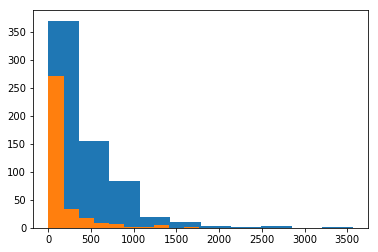

In [129]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(summary_grouped_items(pass_engagement_by_account, 'account_key', 'total_minutes_visited'))
plt.hist(summary_grouped_items(non_pass_engagement_by_account, 'account_key', 'total_minutes_visited'))

(array([317.,  17.,   6.,   4.,   1.,   1.,   0.,   1.,   0.,   1.]),
 array([ 0. ,  2.7,  5.4,  8.1, 10.8, 13.5, 16.2, 18.9, 21.6, 24.3, 27. ]),
 <a list of 10 Patch objects>)

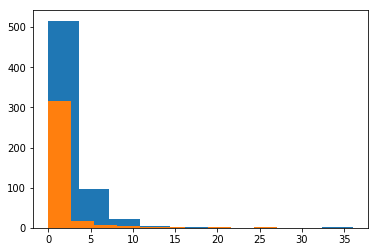

In [130]:
plt.hist(summary_grouped_items(pass_engagement_by_account, 'account_key', 'lessons_completed'))
plt.hist(summary_grouped_items(non_pass_engagement_by_account, 'account_key', 'lessons_completed'))

(array([97., 90., 56.,  0., 41., 15.,  0., 24., 17.,  8.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <a list of 10 Patch objects>)

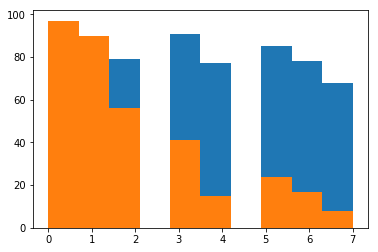

In [131]:
plt.hist(summary_grouped_items(pass_engagement_by_account, 'account_key', 'has_visited'))
plt.hist(summary_grouped_items(non_pass_engagement_by_account, 'account_key', 'has_visited'))

In [132]:
# update describe with ploting at the end
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

def describe_grouped_items(data, key, field):
    
    # summarized
    dict_key_group_items = {}

    for key, items in data.items():
        sum_field = 0
        
        for item in items:
            sum_field += item[field]
        dict_key_group_items[key] = sum_field

    # print data

    grouped_data = list(dict_key_group_items.values())

    print('Mean :', np.mean(grouped_data))
    print('Std Dev :', np.std(grouped_data))
    print('Min :', np.min(grouped_data))
    print('Max :', np.max(grouped_data))
    
    plt.hist(grouped_data)

Mean : 394.58604648350865
Std Dev : 448.4995193265521
Min : 0.0
Max : 3564.7332644989997


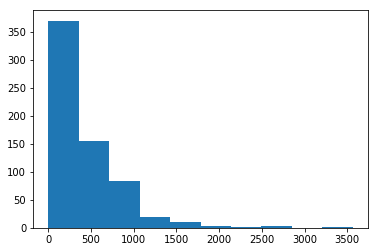

In [133]:
describe_grouped_items(pass_engagement_by_account, 'account_key', 'total_minutes_visited')

### Beautify matplotlit with seaborn

In [140]:
import seaborn as sns

(array([97., 90., 56., 41., 15., 24., 17.,  8.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <a list of 8 Patch objects>)

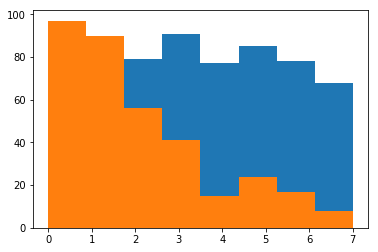

In [144]:
plt.hist(summary_grouped_items(pass_engagement_by_account, 'account_key', 'has_visited'), bins=8)
plt.hist(summary_grouped_items(non_pass_engagement_by_account, 'account_key', 'has_visited'), bins=8)